# Recognizing Facial Expressions
The goal of this notebook is to train a typical CNN model that can recognize facial expressions, such as happiness or confusion.

## About the Data
### Creating the Data
This notebook uses a dataset I created by doing the following:
1. Record a short clip of myself making a facial expression using a webcam and VLC named _expression_.avi  
2. Use ffmpeg to extract 200 images from the short video:  
    1. e.g. `> ffmpeg -i tired.avi -vframes 200 stills/tired-%03d.png`
3. Repeat steps 1 and 2 for nine more expressions  

### Preprocessing
With 2000 images, we have a small dataset that can be trained on. All of the images are the same size, but are much too large and zoomed out to be useful. Some useful functions below will crop images to remove unnecessary data and will resize the images to be 200x200 pixels (arguably still huge for a simple network). No other preprocessing is done at this time.

__Note:__ As you'll see soon, we have limited success with the validation data. There are a number of factors at play that cause the network to utterly fail when trying to classify very similar images recorded at a different time. Some ways to better generalize our network--from a data perspective--include:
1. Normalize the data (tf.image.per_image_standardization) 
2. Train on images from different videos (change lighting, distance, clothes, etc)
3. Perform data augmentation (stretching, rotation, etc)

### Labeling the Data
The above `ffmpeg` command standardizes the filenames used for each image in the dataset. We'll take advantage of that below to simply apply a label based on the filename.

## Load the Libraries

In [1]:
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize

sys.path.append('/notebooks/projects/MNIST/libs')  # Jupyter import fix
%matplotlib inline

# Define our dataset directories
dataset_dir = 'videos/stills/'
dataset_resized = 'videos/resized-stills/'
test_dir = 'videos/valid-stills/'

## Create a Label System
A simple Python Enum helps label each of the images in the dataset.

In [2]:
from enum import Enum
class FaceLabel(Enum):
    neutral = 0
    happy = 1
    angry = 2
    confused = 3
    duck = 4
    sad = 5
    silly = 6
    surprised = 7
    thoughtful = 8
    tired = 9

## Loading and Processing Data
imcrop_tosquare() comes from the Creative Applications of Deep Learning MOOC. Git page located [here](https://github.com/pkmital/CADL). load_images() loads all images specified in the `path` parameter and generates a label based on the filename while cropping and resizing if necessary

In [3]:
def imcrop_tosquare(img, trim=0):
    """Make any image a square image.
    Parameters
    ----------
    img : np.ndarray
        Input image to crop, assumed at least 2d.
    trim : Integer
        Take off a few extra pixels, if you please. 
    Returns
    -------
    crop : np.ndarray
        Cropped image.
    """
    size = np.min(img.shape[:2]) - trim
    extra = img.shape[:2] - size
    crop = img
    for i in np.flatnonzero(extra):
        crop = np.take(crop, extra[i] // 2 + np.r_[:size], axis=i)
    return crop

def load_images(path, crop_and_resize=False, trim=50):
    imgs = []
    labels = []
    filenames = os.listdir(path)
    for filename in filenames:
        labels += [FaceLabel[filename.split('-')[0]].value]
        img = plt.imread(os.path.join(path, filename))[:, :, :3]  # ignore alpha channel
        if crop_and_resize:
            cropped = imcrop_tosquare(img, trim=trim)
            img = resize(cropped, (200, 200))
        imgs += [img]
    imgs = np.asarray(imgs)
    labels = np.asarray(labels)
    return imgs, labels, filenames

Here we'll actually import the data; for convenience, the 200x200 images will be saved so they can be loaded next time without having to process the entire dataset again.

In [4]:
imgs = None
labels = None
print('Loading images')
if os.path.isdir(dataset_resized) and len(os.listdir(dataset_resized)) > 0:
    print('Resized images already exist. Loading...')
    imgs, labels, _ = load_images(dataset_resized)
else:
    print('Images need to be cropped, resized, and saved. This may take some time...')
    imgs, labels, filenames = load_images(dataset_dir, crop_and_resize=True)
    # Save resized images, so we don't have to load & resize again next time
    if not os.path.exists(dataset_resized):
        os.makedirs(dataset_resized)
    print('Saving resized images')
    for img, filename in zip(imgs, filenames):
        plt.imsave(os.path.join(dataset_resized, filename), img)  # Saves an alpha channel, we ignore it above ^
        
assert imgs[0].shape == (200, 200, 3)
print('Done!')

Loading images
Resized images already exist. Loading...
Done!


Let's take a look at one of the images:

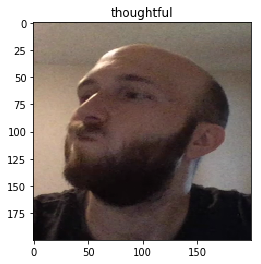

In [6]:
index = np.random.randint(0,100)
plt.title(FaceLabel(labels[index]).name)
plt.imshow(imgs[index])

### One Hote Encode Labels
We'll use a TensorFlow Graph to generate one-hot encodings of our labels for fun (and because we need them)

In [7]:
# Convert labels to one-hot (using tf for fun):
one_hot_graph = tf.Graph()
one_hot_session = tf.Session(graph=one_hot_graph)
with one_hot_graph.as_default():
    label_input = tf.placeholder(tf.int32)
    one_hot = tf.one_hot(label_input, 10)
label_one_hot = np.asarray(one_hot.eval(feed_dict={label_input: labels}, session=one_hot_session))

Next, we'll load our validation data and one-hot encode it as well:

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


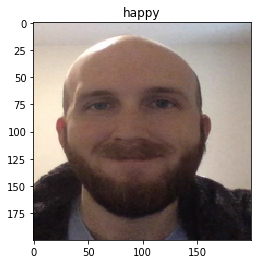

In [8]:
validation_imgs, validation_labels, _ = load_images(test_dir, crop_and_resize=True)
validation_labels_one_hot = np.asarray(one_hot.eval(feed_dict={label_input: validation_labels}, session=one_hot_session))
plt.title(FaceLabel(validation_labels[0]).name)
plt.imshow(validation_imgs[0])

# Non-Dataset Approach
TensorFlow 1.4 adds a new `Dataset` type which makes handling large datasets a breeze. While I'll explore this in other notebooks, we'll do a more typical, naive approach for simplicity. To that end, we need a shuffle function for randomizing the data order during training.

In [9]:
def shuffle(a, b):
    assert len(a) == len(b)
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

### Split the Dataset
The dataset is split into training and testing groups. Considering how the data was generated, even a very lopsided split (400 training images) will perform excellently on the test dataset. 

In [10]:
train_imgs = imgs.copy()[:1000]
train_labels = label_one_hot.copy()[:1000]
test_imgs = imgs.copy()[1000:]
test_labels = label_one_hot.copy()[1000:]

# Training and Everything Else

## Convenience Functions
These are some simple functions used for defining the network graph. `std` is used for initializing our weights, while `conv2d` and `max_pool` make our convolutional layer definitions simpler.

In [11]:
def std(inputs):
    return 1 / math.sqrt(inputs)
def conv2d(x, w, strides=[1,1,1,1], padding='SAME'):
    return tf.nn.conv2d(x, w, strides=strides, padding=padding)

def max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'):
    return tf.nn.max_pool(x, ksize=ksize, strides=strides, padding=padding)

## The Workhorse

The following occurs in the next code piece:
1. Define the network
2. Train the network
    1. Test the Network
    2. Validate the Network  

### Network Definition
The network is defined as such:
1. A conv2d layer with a 5x5 convolution and 8 features followed by a pooling layer
2. Another conv2d layer with 16 features and another pooling layer (output reduced to 50x50 after this)
3. A fully-connected 1024 node ReLU layer with dropout
4. Another fully-connected 1024 node ReLU layer with dropout
5. A softmax output layer
6. Adam Optimization  

### Network Training
Batches of 20 images are grabbed and trained on; this is done 500 times with training and testing accuracy displayed periodically. At the end, the validation data is run through the network, which fails horribly

In [14]:
batches = 500
batch_size = 20
show_train_accuracy = 20
show_test_accuracy = 100
# 1. Define the network
network_graph = tf.Graph();
network_session = tf.Session(graph=network_graph)
with network_graph.as_default():
    # Input images and labels
    X = tf.placeholder(tf.float32, [None, 200, 200, 3])
    y_ = tf.placeholder(tf.float32, [None, 10])
    keep_prob = tf.placeholder(tf.float32)
    # Conv Layer 1
    w_conv1 = tf.Variable(tf.truncated_normal([5, 5, 3, 8], stddev=std(200 * 200 * 3)))
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[8]))
    h_conv1 = tf.nn.relu(conv2d(tf.reshape(X, [-1, 200, 200, 3]), w_conv1) + b_conv1)
    h_pool1 = max_pool(h_conv1)
    # Conv Layer 2
    w_conv2 = tf.Variable(tf.truncated_normal([5, 5, 8, 16], stddev=std(5 * 5 * 8)))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[16]))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
    h_pool2 = max_pool(h_conv2)
    h_pool2_flat = tf.reshape(h_pool2, [-1, 16*50*50])
    # FC Layer 1
    w_fc1 = tf.Variable(tf.truncated_normal([16*50*50, 1024], stddev=std(16*50*50)))
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    # FC Layer 2 (Output Layer)
    w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=std(1024*10)))
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
    y_conv = tf.matmul(h_fc1_drop, w_fc2) + b_fc2

    softmax = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(softmax)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 2. Train the Network
with network_session as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(batches):
        shuffle(train_imgs, train_labels)  # Not the most efficient, since we'll only use 20 images
        batch = (train_imgs[:batch_size], train_labels[:batch_size])
        
        train_step.run(feed_dict={X: batch[0], y_: batch[1], keep_prob: 0.5})
        
        # 2.A Test the Network
        if i % show_train_accuracy == 0:
            train_accuracy = accuracy.eval(feed_dict={
              X: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        if i % show_test_accuracy == 0:
            print('test accuracy %g' % accuracy.eval(feed_dict={
                  X: test_imgs, y_: test_labels, keep_prob: 1.0}))
            
    # Show Testing and Validation Accuracy at the end
    print('test accuracy %g' % accuracy.eval(feed_dict={
        X: test_imgs, y_: test_labels, keep_prob: 1.0}))
    test_result = correct_prediction.eval(feed_dict={X: test_imgs, y_: test_labels, keep_prob: 1.0})
    test_output = y_conv.eval(feed_dict={X: test_imgs, y_: test_labels, keep_prob: 1.0})
    # 2.B Validate the Network
    print('validation accuracy %g' % accuracy.eval(feed_dict={
        X: validation_imgs, y_: validation_labels_one_hot, keep_prob: 1.0}))
    
    validation_result = correct_prediction.eval(feed_dict={X: validation_imgs, y_: validation_labels_one_hot, keep_prob: 1.0})
    validation_output = y_conv.eval(feed_dict={X: validation_imgs, y_: validation_labels_one_hot, keep_prob: 1.0})

step 0, training accuracy 0.2
test accuracy 0.099
step 20, training accuracy 0.15
step 40, training accuracy 0.1
step 60, training accuracy 0.4
step 80, training accuracy 0.3
step 100, training accuracy 0.5
test accuracy 0.603
step 120, training accuracy 0.7
step 140, training accuracy 0.85
step 160, training accuracy 0.85
step 180, training accuracy 1
step 200, training accuracy 0.9
test accuracy 0.839
step 220, training accuracy 0.95
step 240, training accuracy 1
step 260, training accuracy 1
step 280, training accuracy 0.95
step 300, training accuracy 1
test accuracy 0.976
step 320, training accuracy 1
step 340, training accuracy 1
step 360, training accuracy 1
step 380, training accuracy 1
step 400, training accuracy 0.95
test accuracy 0.997
step 420, training accuracy 1
step 440, training accuracy 1
step 460, training accuracy 1
step 480, training accuracy 1
test accuracy 0.991
validation accuracy 0


## Results
Here is the confusion matrix for the test data:

In [15]:
with tf.Session() as sess:
    confusion = tf.confusion_matrix(np.argmax(test_labels, 1), np.argmax(test_output, 1)).eval()
confusion.tolist()

[[98, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 100, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 106, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 100, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 100, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 99, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 91, 9, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 99, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 100, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 98]]

And another confusion matrix for the validation data:

__Note__: In this case, I just have 50 images classified as _happy_, but previous tests including other labels were just as bad, basically all defaulting to one classification, or 10% accuracy.

In [16]:
with tf.Session() as sess:
    valid_confusion = tf.confusion_matrix(np.argmax(validation_labels_one_hot, 1), np.argmax(validation_output, 1)).eval()
valid_confusion.tolist()

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 50],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

## What Went Wrong
The network not only achieved 100% training accuracy, generally a sign of overfitting, but also achieved 99.7% testing accuracy, yet the validation accuracy utterly failed. In the __Preprocessing__ section, I discussed some data approaches for preventing this from happening, but there are some training and network changes we could make as well. Some of those improvements includes:
1. Early stopping
2. Tweaking the convolutional layers to use larger/smaller kernels
3. Adding/Removing features
4. Trying a different optimizer  

I'd like to leave this notebook as it is. It is a testament to how readily a network can overfit on a small dataset.

### When in doubt, _get more data_!